# QF 627 Extras - Financial Analytics
## Lesson 7 | Synthetic Controls and Counterfactual Predictions

> Hi, Team 👋 Thank you for opening the script 🙂

> We’re starting the second half of the semester with synthetic control, which we’ll cover over the two weeks (Lesson 7 and Lesson 8). The current lecture note serves as pre-reading material for next week’s lesson.

> Importantly, synthetic control acts as a bridge between the causal inference methods we’ve studied so far and the predictive modeling with machine learning that we’ll explore in Weeks 9 and 10.

> Tonight’s guest lecture will focus on machine learning. As discussed, this is intentionally scheduled to support a progressive transition into the predictive modeling segment of our course.

## DEPENDENCIES

In [1]:
# Load libraries.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time

import datetime
import re

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

# Setting baseline seed
np.random.seed(2025)

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

# Define our customized timer function

def countdown(Time):
    
    while Time:
        minutes, seconds = divmod(Time, 60)
        timer = "{:02d}:{:02d}".format(minutes, seconds)
        
        print(timer, end = "\r")
        time.sleep(1)
        Time -= 1
        
    print("Let us solve the problem above together :)")

In [2]:
%whos

Variable    Type        Data/Info
---------------------------------
countdown   function    <function countdown at 0x106dedd00>
datetime    module      <module 'datetime' from '<...>/python3.13/datetime.py'>
mpl         module      <module 'matplotlib' from<...>/matplotlib/__init__.py'>
np          module      <module 'numpy' from '/op<...>kages/numpy/__init__.py'>
pd          module      <module 'pandas' from '/o<...>ages/pandas/__init__.py'>
plt         module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
re          module      <module 're' from '/opt/h<...>thon3.13/re/__init__.py'>
sm          module      <module 'statsmodels.api'<...>ages/statsmodels/api.py'>
sns         module      <module 'seaborn' from '/<...>ges/seaborn/__init__.py'>
time        module      <module 'time' (built-in)>
warnings    module      <module 'warnings' from '<...>/python3.13/warnings.py'>


## 👉 <a id = "top">Learning Pointers</a> 👈 

## [1. Synthetic Control](#p1)

> ### <font color = red> A Simple, yet Powerful Math Trick </font>

## [2. What We Learned & What's Next](#p2)

> ### <font color = red> Revisiting Learning Pointers </font>


## <a id = "p1">1. </a> <font color = "green"> Synthetic Control: A Simple, Yet Powerful Math Trick </font>  [back to table of contents](#top)

### Analytics Contexts

> When we looked at difference-in-differences, we had data on multiple customers from two different cities: Madrid and Barcelona. The data spanned two different time periods: before and after a marketing intervention was conducted in Madrid to boost customer deposits. To estimate the treatment effect, we ran a regression that gave us the difference-in-difference estimator and its standard error.

> In that case, we had a lot of samples because the data was disaggregated. But what if all we have is aggregated data at the city level? For instance, let's pretend all we have is the average level of deposits in both cities before and after the intervention.

|city|before|after|
|--|--|--|
|Madrid|B|A|
|Barcelona|D|C|

> We would still be able to compute the DiD estimator:

$$
(E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0])
$$

> However, note that the sample size here is four, which is also the number of parameters in our DiD model. In this case, the standard error is not well-defined, so what should we do? 

> Another problem is that Barcelona might not be as similar to Madrid as we would like it to be. For instance, Barcelona is known for its beautiful beaches and easy-going people while Madrid is more famous for its museum. The problem here is that you can never know for sure if you are using an appropriate control group.

> To work around this, we will use what is known as the most important innovation in the causal inference in the last few years: namely, `Synthetic Controls`. 

> It is based on a simple yet powerful idea. We do not need to find any single unit in the untreated group that is very similar to the treated group. Instead, we can create our own as a combination of multiple untreated units, creating what is effectively a synthetic control.

### Business Contexts

> To see this concept in action, let's consider the problem of estimating the effect of cigarette taxation on consumption. This is a question that has been debated for a long time in economics. One side of the argument suggests that taxes increase the cost of cigarettes, which will lower their demand. The other side argues that since cigarettes cause addiction, changes in their price won't affect their demand by much. In economic terms, we would say that the demand for cigarettes is inelastic with respect to price, and an increase in taxation is just a way to increase government income at the cost of smokers. To settle the debate, we will examine some US data related to this issue.

> In 1988, California passed the famous Tobacco Tax and Health Protection Act, also known as Proposition 99. "Its primary effect is to impose a 25-cent per pack state excise tax on the sale of tobacco cigarettes within California, with approximately equivalent excise taxes similarly imposed on the retail sale of other commercial tobacco products, such as cigars and chewing tobacco. Additional restrictions placed on the sale of tobacco include a ban on cigarette vending machines in public areas accessible by juveniles and a ban on the individual sale of single cigarettes. Revenue generated by the act was earmarked for various environmental and healthcare programs and anti-tobacco advertisements."

> To evaluate its effect, we can gather data on cigarette sales from multiple states across a number of years. In this case, we obtained data from 39 states for the years 1970 to 2000. Other states with similar tobacco control programs were dropped from the analysis. Here is what our data looks like.

### IMPORT 

In [3]:
smoking =\
(
    pd
    .read_csv("https://talktoroh.squarespace.com/s/tobacco.csv")
)

In [4]:
smoking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state            1209 non-null   int64  
 1   year             1209 non-null   int64  
 2   cigsale          1209 non-null   float64
 3   retprice         1209 non-null   float64
 4   california       1209 non-null   bool   
 5   after_treatment  1209 non-null   bool   
dtypes: bool(2), float64(2), int64(2)
memory usage: 40.3 KB


In [5]:
smoking.head(10)

,state,year,cigsale,retprice,california,after_treatment
0,1,1970,89.800003,39.599998,False,False
1,1,1971,95.400002,42.700001,False,False
2,1,1972,101.099998,42.299999,False,False
3,1,1973,102.900002,42.099998,False,False
4,1,1974,108.199997,43.099998,False,False
5,1,1975,111.699997,46.599998,False,False
6,1,1976,116.199997,50.400002,False,False
7,1,1977,117.099998,50.099998,False,False
8,1,1978,123.000000,55.099998,False,False
9,1,1979,121.400002,56.799999,False,False


In [6]:
smoking["state"].unique() # state = 3 California

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])

### WRANGLE + VISUALIZATION = `E`xploratory `D`ata `A`nalysis (`EDA`)

In [7]:
(
    smoking
    .query("state == 3") # choosing observations of interest
)

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False
67,3,1975,127.099998,45.000000,True,False
68,3,1976,128.000000,48.299999,True,False
69,3,1977,126.400002,49.000000,True,False
70,3,1978,126.099998,58.700001,True,False
71,3,1979,121.900002,60.099998,True,False


In [8]:
(
    smoking
    .query("california")
)

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False
67,3,1975,127.099998,45.000000,True,False
68,3,1976,128.000000,48.299999,True,False
69,3,1977,126.400002,49.000000,True,False
70,3,1978,126.099998,58.700001,True,False
71,3,1979,121.900002,60.099998,True,False


### Naive Comparisons from `observation`

In [9]:
smoking.columns

Index(['state', 'year', 'cigsale', 'retprice', 'california',
       'after_treatment'],
      dtype='object')

### Chaining Method

In [10]:
# wrangled_df =\
( # usefulness of chaining of your codes
    smoking # DF         # np.where(RULE, True, False)
    .assign(california = np.where(smoking["california"], "California", "Other States")
           ) # Treatment (California vs. Other States)
                         # Treated   vs. Controlled
    .groupby(["year", "california"] # unit of analysis: year x california --> index
            )
    [["cigsale"]]
    .mean()
).reset_index().pivot(index = "year",
                      columns = "california",
                      values = "cigsale")

california,California,Other States
year,,
1970,123.000000,120.084212
1971,121.000000,123.863158
1972,123.500000,129.178948
1973,124.400002,131.539473
1974,126.699997,134.668421
1975,127.099998,136.931579
1976,128.000000,141.260526
1977,126.400002,141.089473
1978,126.099998,140.473684


### Modularization Method

In [11]:
wrangled_df =\
( # usefulness of chaining of your codes
    smoking # DF         # np.where(RULE, True, False)
    .assign(california = np.where(smoking["california"], "California", "Other States")
           ) # Treatment (California vs. Other States)
                         # Treated   vs. Controlled
    .groupby(["year", "california"] # unit of analysis: year x california --> index
            )
    [["cigsale"]]
    .mean()
)

In [12]:
pivoted_df =\
(
    wrangled_df
    .reset_index()
    .pivot(index = "year",
           columns = "california",
           values = "cigsale")
)

In [13]:
pivoted_df

california,California,Other States
year,,
1970,123.000000,120.084212
1971,121.000000,123.863158
1972,123.500000,129.178948
1973,124.400002,131.539473
1974,126.699997,134.668421
1975,127.099998,136.931579
1976,128.000000,141.260526
1977,126.400002,141.089473
1978,126.099998,140.473684


### Matplotlib Visuals

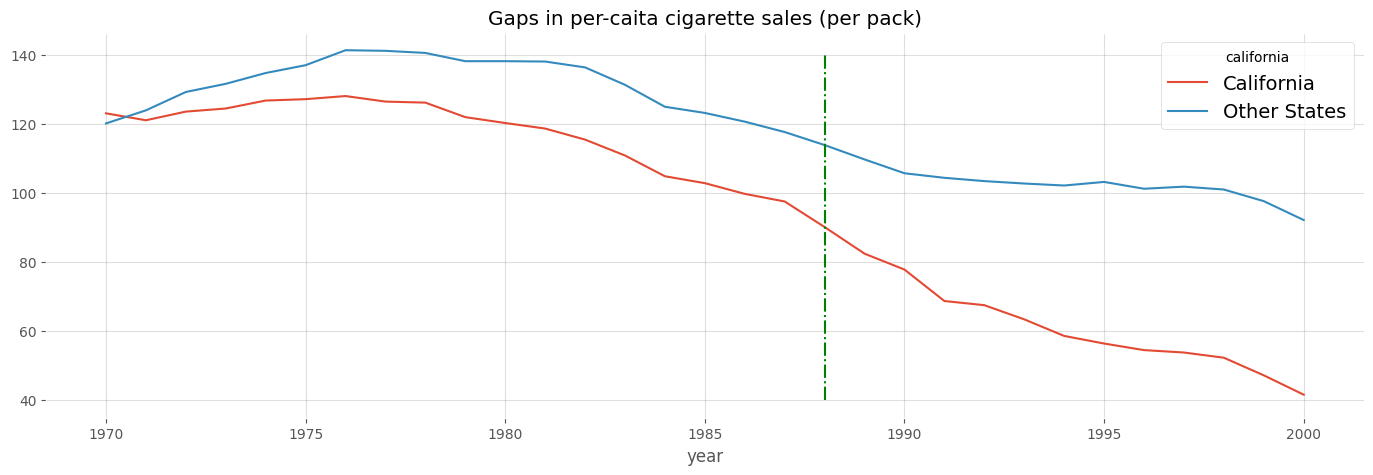

In [14]:
(
    pivoted_df
    .plot(figsize = [17, 5]
         )
)

plt.title("Gaps in per-caita cigarette sales (per pack)")

plt.vlines(x = 1988,
           ymax = 140,
           ymin = 40,
           color = "green",
           ls = "-.",
           label = "Policy (Your Strategy) Implementation")

plt.show()

### Grammar of Graphics Visuals

In [15]:
ggplot_df =\
(
    wrangled_df
    .reset_index()
)

In [16]:
from lets_plot import *
LetsPlot.setup_html()

In [17]:
ggplot_df.head(3)

,year,california,cigsale
0,1970,California,123.000000
1,1970,Other States,120.084212
2,1971,California,121.000000


In [18]:
ggplot_df =\
(
    ggplot_df # DF                # RULE                   , True   , False
    .assign(timeframe = np.where(ggplot_df["year"] <= 1987, "Before", "After")
           )
)

ggplot_df

,year,california,cigsale,timeframe
0,1970,California,123.000000,Before
1,1970,Other States,120.084212,Before
2,1971,California,121.000000,Before
3,1971,Other States,123.863158,Before
4,1972,California,123.500000,Before
...,...,...,...,...
57,1998,Other States,100.957894,After
58,1999,California,47.200001,After
59,1999,Other States,97.594737,After
60,2000,California,41.599998,After


In [19]:
(
    ggplot(ggplot_df,
           aes(x = "year",
               y = "cigsale" #,
              # group = "california"
              )
          ) 
    + geom_line(aes(color = "california")
               )
    + geom_point(aes(color = "california")
                )
    + geom_vline(xintercept = 1988,
                 color = "green")
    + facet_grid(y = "timeframe")
    + theme(legend_position = "top")
)

### The construction of synthetic control unit

$$
    \text{Synthetic Contol} = \sum_{j = 1}^{J} w_j X_j
$$

- $X_j$ denotes the characteristics (e.g., economic indicators, demographics) of each potential control unit \( j\).

- $w_j$ denotes the weights assigned to each control unit (here, other states), determined in a way that the pre-strategy characteristics of the synthetic control closely match those of the treated unit (here, California).

- The sum runs over all \( J \) control units considered in your causal inference (analysis).

### NOTE: ~, out of formula, denotes NOT

In [20]:
(
    smoking
    .query("~after_treatment") # before treatment
    .pivot(index = "state",
           columns = "year")
    [["cigsale"]]
)

cigsale                                                              \
year         1970        1971        1972        1973        1974        1975   
state                                                                           
1       89.800003   95.400002  101.099998  102.900002  108.199997  111.699997   
2      100.300003  104.099998  103.900002  108.000000  109.699997  114.800003   
3      123.000000  121.000000  123.500000  124.400002  126.699997  127.099998   
4      124.800003  125.500000  134.300003  137.899994  132.800003  131.000000   
5      120.000000  117.599998  110.800003  109.300003  112.400002  110.199997   
6      155.000000  161.100006  156.300003  154.699997  151.300003  147.600006   
7      109.900002  115.699997  117.000000  119.800003  123.699997  122.900002   
8      102.400002  108.500000  126.099998  121.800003  125.599998  123.300003   
9      124.800003  125.599998  126.599998  124.400002  131.899994  131.800003   
10     134.600006  139.300003  149.199997  156.000000  159.600006  162.399994   
11     108.500000  108.400002  109.400002  110.599998  116.099998  120.500000   
12     114.000000  102.800003  111.000000  115.199997  118.599998  123.400002   
13     155.800003  163.500000  179.399994  201.899994  212.399994  223.000000   
14     115.900002  119.800003  125.300003  126.699997  129.899994  133.600006   
15     128.500000  133.199997  136.500000  138.000000  142.100006  140.699997   
16     104.300003  116.400002   96.800003  106.800003  110.599998  111.500000   
17      93.400002  105.400002  112.099998  115.000000  117.099998  116.800003   
18     121.300003  127.599998  130.000000  132.100006  135.399994  135.600006   
19     111.199997  115.599998  122.199997  119.900002  121.900002  123.699997   
20     108.099998  108.599998  104.900002  106.599998  110.500000  114.099998   
21     189.500000  190.500000  198.600006  201.500000  204.699997  205.199997   
22     265.700012  278.000000  296.200012  279.000000  269.799988  269.100006   
23      90.000000   92.599998   99.300003   98.900002  100.300003  103.099998   
24     172.399994  187.600006  214.100006  226.500000  227.300003  226.000000   
25      93.800003   98.500000  103.800003  108.699997  110.500000  117.900002   
26     121.599998  124.599998  124.400002  120.500000  122.099998  122.500000   
27     108.400002  115.400002  121.699997  124.099998  130.500000  132.899994   
28     107.300003  106.300003  109.000000  110.699997  114.199997  114.599998   
29     123.900002  123.199997  134.399994  142.000000  146.100006  154.699997   
30     103.599998  115.000000  118.699997  125.500000  129.699997  130.500000   
31      92.699997   96.699997  103.000000  103.500000  108.400002  113.500000   
32      99.800003  106.300003  111.500000  109.699997  114.800003  117.400002   
33     106.400002  108.900002  108.599998  110.400002  114.699997  116.000000   
34      65.500000   67.699997   71.300003   72.699997   75.599998   75.800003   
35     122.599998  124.400002  138.000000  146.800003  151.800003  155.500000   
36     124.300003  128.399994  137.000000  143.100006  149.600006  152.699997   
37     114.500000  111.500000  117.500000  116.599998  119.900002  123.199997   
38     106.400002  105.400002  108.800003  109.500000  111.800003  113.500000   
39     132.199997  131.699997  140.000000  141.199997  145.800003  160.699997   

                                                                               \
year         1976        1977        1978        1979        1980        1981   
state                                                                           
1      116.199997  117.099998  123.000000  121.400002  123.199997  119.599998   
2      119.099998  122.599998  127.300003  126.500000  131.800003  128.699997   
3      128.000000  126.400002  126.099998  121.900002  120.199997  118.599998   
4      134.199997  132.000000  129.199997  131.500000  131.000000  133.800003   
5      113.400002  117.300003  117.50000

### Learn how to learn

In [21]:
data =\
(
    pd
    .DataFrame(
        {"year" : [2007, 2007, 2007, 2007, # 2007
                   2008, 2008, 2008, 2008, # 2008
                   2009, 2009, 2009, 2009, # 2009
                   2010, 2010, 2010, 2010], # 2010
        "city": ["cityA", "cityB", "cityC", "cityD"] * 4,
        "sales": [1000, 950, 1100, 1050,
                  1020, 960, 1110, 1060,
                  1010, 955, 1120, 1045,
                   800, 970, 1130, 1070]
        }
    )
)

data

,year,city,sales
0,2007,cityA,1000
1,2007,cityB,950
2,2007,cityC,1100
3,2007,cityD,1050
4,2008,cityA,1020
5,2008,cityB,960
6,2008,cityC,1110
7,2008,cityD,1060
8,2009,cityA,1010
9,2009,cityB,955


In [22]:
data.city.unique()

array(['cityA', 'cityB', 'cityC', 'cityD'], dtype=object)

In [23]:
treated_unit = "cityA"
controlled_unit = ['cityB', 'cityC', 'cityD']

intervention_year = 2010

pre_period = [2007, 2008, 2009]
post_period = [2010]

In [24]:
data.head(3)

,year,city,sales
0,2007,cityA,1000
1,2007,cityB,950
2,2007,cityC,1100


In [25]:
df_sales =\
(
    data
    .pivot(index = "year",
           columns = "city",
           values = "sales")
)

df_sales

city,cityA,cityB,cityC,cityD
year,,,,
2007,1000,950,1100,1050
2008,1020,960,1110,1060
2009,1010,955,1120,1045
2010,800,970,1130,1070


In [26]:
A_pre =\
(
    df_sales
    .loc[pre_period, treated_unit]
).values

In [27]:
B_pre =\
(
    df_sales
    .loc[pre_period, "cityB"]
).values

In [28]:
C_pre =\
(
    df_sales
    .loc[pre_period, "cityC"]
).values

In [29]:
D_pre =\
(
    df_sales
    .loc[pre_period, "cityD"]
).values

### Let's calculated Synthetic City A --> What would have happened without intervention in City A

In [30]:
def calculate_weights(weights):
    wB, wC, wD = weights
    synthetic = wB * B_pre + wC * C_pre + wD * D_pre
    return np.sum((A_pre - synthetic) ** 2) 
    # team, please take a look at the sum of squared differences equation :)

In [31]:
### Weightages in sum should be at 1

### wB + wC + wD = 1

constraints = ({"type": "eq", "fun": lambda w: w[0] + w[1]+ w[2] - 1}
               )

In [32]:
### The range of weights should between 0% through 100%

range_of_weights = [(0,1), (0,1), (0,1)
                   ]

In [33]:
### Equal weightage (BAD --> Don't use this)

weights_by_intuition = [1/3, 1/3, 1/3]

In [34]:
# minization function comes from scipy

from scipy.optimize import minimize

In [35]:
### Solving Math Problem of Optimized Weights

solution =\
( # scipy optimization tool-kit --> scipy.optimize 
    minimize(calculate_weights,
             weights_by_intuition,
             method = "SLSQP",  # Sequential Least Squares Programming
             bounds = range_of_weights,
             constraints = constraints)
)

In [36]:
### Obtain Optmized Weights

wB_optimized, wC_optimized, wD_optimized = solution.x

print("Team, here are optimized weights:")
print(f" CityB: {wB_optimized:.2f}")
print(f" CityC: {wC_optimized:.2f}")
print(f" CityD: {wD_optimized:.2f}")

Team, here are optimized weights:
 CityB: 0.54
 CityC: 0.18
 CityD: 0.27


### Let's use the weights for generating synthetic City A

In [37]:
B_allyears = df_sales["cityB"]
C_allyears = df_sales["cityC"]
D_allyears = df_sales["cityD"]

In [38]:
synthetic_allyears =\
(
    wB_optimized * B_allyears 
    + wC_optimized * C_allyears 
    + wD_optimized * D_allyears
)

### Compare Apple to Apple: City A versus Synthetic City A

In [39]:
comparable_df =\
(
    pd
    .DataFrame(
        {"City_A": df_sales["cityA"],
         "Synthetic_City_A": synthetic_allyears}
    )
)

comparable_df

,City_A,Synthetic_City_A
year,,
2007,1000,1004.999838
2008,1020,1014.999838
2009,1010,1009.999822
2010,800,1026.833161


### Algorithmic Decision Making on Method of Causal Inference

In [40]:
def would_you_recommend_causal_inference_method():
    print("Welcome to the Causal Inference Recommender architected by Prof. Roh :)")
    print("Please answer to the following questions with either 'y' or 'n'.\n")

    # Question 1. RCT Feasibility (from observation to intervention)
    can_randomized = input("Question 1: Can we RANDOMIZE the treatment assignment? (y / n): ").strip().lower()
    if can_randomized == "y":
        print("\nRecommended Method: **RCTs (Randomized Controlled Trials)**")
        return

    # Question 2. Threshold for RDD
    has_threshold = input("Question 2: Is there a threshold that assigns treatment (e.g., cut-off) (y / n): ?").strip().lower()
    if has_threshold == "y":
        print("\nRecommended Method: **RDD (Regression Discontinuity Design)")
        return

    # Question 3. Check for Panel (vs. Cross-sectional) or Time-Series Data
    has_panel_data = input("Question 3: Do we have panel (longitudinal) or repeated Cross-Sectional Data over Time? (y / n): ").strip().lower()
    if has_panel_data == "y":
        # contingency

        # Question 4. Do we have single or multiple treated units
        single_treated = input("Question 4: Do you have ONLY ONE treated unit (e.g., one city, one district)? (y / n): ").strip().lower()
        
        if single_treated == "y":
            
            parallel_trends = input("Question 5: Are we confident the 'parallel trends' assumption would hold if you used a DiD? (y / n): ").strip().lower()

            if parallel_trends == "y":
                print("\nParallel trends might hold, but you still only have ONE TREATED UNIT...")
                print("\nRecommended Method: **Difference-in-Differences is fine.**"
                     )
            else:
                print("\nSince parallel trends are questionable and there's only ONE TREATED UNIT...")
                print("\nRecommended Method: **Synthetic Control**")
            return

        else: 
            parallel_trends = input("Question 5: Can we assume paraell trends with multiple treated units? (y / n ): ").strip().lower()
            if parallel_trends == "y":
                print("\nRecommended Method: **Difference-in-Differences (DiD) ** ")
                return
            else: 
                print("\nParallel trends are questionable for multiple treated units.")
                print("\nTeam, you should consider more advanced methods as follows:")
                print("\n - Matching along with DiD (to align pre-trends on a matched sample.")
                print("\n - Synthetic Control for subsets if feasible")
                print("\n - More advanced methods ... call Prof. Roh :)")
                return

    else: 
        print("\n Recommended Method: **Matching** (Propensity Scoring and Inverse Probability Weights (**IPW**).")
        return

In [41]:
would_you_recommend_causal_inference_method()

Welcome to the Causal Inference Recommender architected by Prof. Roh :)
Please answer to the following questions with either 'y' or 'n'.



Question 1: Can we RANDOMIZE the treatment assignment? (y / n):  n
Question 2: Is there a threshold that assigns treatment (e.g., cut-off) (y / n): ? n
Question 3: Do we have panel (longitudinal) or repeated Cross-Sectional Data over Time? (y / n):  y
Question 4: Do you have ONLY ONE treated unit (e.g., one city, one district)? (y / n):  y
Question 5: Are we confident the 'parallel trends' assumption would hold if you used a DiD? (y / n):  n



Since parallel trends are questionable and there's only ONE TREATED UNIT...

Recommended Method: **Synthetic Control**


In [42]:
smoking.head(3)

,state,year,cigsale,retprice,california,after_treatment
0,1,1970,89.800003,39.599998,False,False
1,1,1971,95.400002,42.700001,False,False
2,1,1972,101.099998,42.299999,False,False


In [43]:
# Preparation Data for Synthetic California 

prep_for_building_synthetic_control =\
(
    smoking
    .query("~after_treatment") # returns before treatment
    .pivot(index = "state",
           columns = "year")
    [["cigsale", "retprice"]]
).T

In [44]:
prep_for_building_synthetic_control.head(3)

state                 1           2      3           4           5   \
        year                                                          
cigsale 1970   89.800003  100.300003  123.0  124.800003  120.000000   
        1971   95.400002  104.099998  121.0  125.500000  117.599998   
        1972  101.099998  103.900002  123.5  134.300003  110.800003   

state                 6           7           8           9           10  ...  \
        year                                                              ...   
cigsale 1970  155.000000  109.900002  102.400002  124.800003  134.600006  ...   
        1971  161.100006  115.699997  108.500000  125.599998  139.300003  ...   
        1972  156.300003  117.000000  126.099998  126.599998  149.199997  ...   

state                 30          31          32          33         34  \
        year                                                              
cigsale 1970  103.599998   92.699997   99.800003  106.400002  65.500000   
        1971  115.000000   96.699997  106.300003  108.900002  67.699997   
        1972  118.699997  103.000000  111.500000  108.599998  71.300003   

state                 35          36     37          38          39  
        year                                                         
cigsale 1970  122.599998  124.300003  114.5  106.400002  132.199997  
        1971  124.400002  128.399994  111.5  105.400002  131.699997  
        1972  138.000000  137.000000  117.5  108.800003  140.000000  

[3 rows x 39 columns]

In [45]:
california =\
(
    prep_for_building_synthetic_control
    [3]
    .values
)

In [46]:
california

array([123. , 121. , 123.5, 124.4, 126.7, 127.1, 128. , 126.4, 126.1,
       121.9, 120.2, 118.6, 115.4, 110.8, 104.8, 102.8,  99.7,  97.5,
        90.1,  38.8,  39.7,  39.9,  39.9,  41.9,  45. ,  48.3,  49. ,
        58.7,  60.1,  62.1,  66.4,  72.8,  84.9,  94.9,  98. , 104.4,
       103.9, 117.4])

In [47]:
other_states =\
(
    prep_for_building_synthetic_control
    # .loc[3, : ]
    .drop(columns = 3)
    .values
)

In [48]:
other_states # 2d-array

array([[ 89.8, 100.3, 124.8, ..., 114.5, 106.4, 132.2],
       [ 95.4, 104.1, 125.5, ..., 111.5, 105.4, 131.7],
       [101.1, 103.9, 134.3, ..., 117.5, 108.8, 140. ],
       ...,
       [103. , 103.6,  95.1, ..., 104.1, 110.8,  97.8],
       [110. , 113. , 108.6, ..., 112.8, 116.3, 102.7],
       [114.4, 119.9, 116. , ..., 122.2, 128.6, 112.9]], shape=(38, 38))

In [49]:
from sklearn.linear_model import LinearRegression

ols_model_estimated =\
(
    LinearRegression(fit_intercept = False)
    .fit(other_states, california)
)

In [50]:
weights_obtained_from_regression =\
(
    LinearRegression(fit_intercept = False)
    .fit(other_states, california)
    .coef_
)

weights_obtained_from_regression

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

In [51]:
synthetic_california_obtained_from_regression_weights =\
(
    smoking
    .query("~california")
    .pivot(index = "year",
           columns = "state")
    ["cigsale"]
    .values
    .dot(weights_obtained_from_regression)
)

> Team, we need `matrix product`

In [52]:
x =\
    [
        [0, 1],
        [1, 0]
    ]

y =\
    [
        [1, 2],
        [3, 4]
    ]

np.dot(x, y)

array([[3, 4],
       [1, 2]])

### NOT so optimized synthetic controls

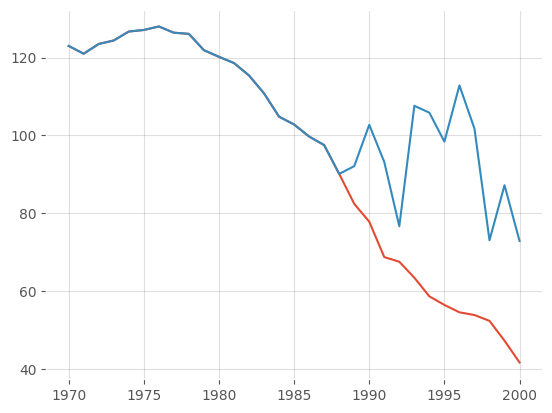

In [53]:
# Observation
(
    plt
    .plot(smoking.query("california").year,
          smoking.query("california").cigsale,
         label = "California before vs. after Treatment")
)

# Estimation --> Counterfactual Predictions (What would have happened to California without the policy)

(
    plt
    .plot(smoking.query("california").year,
          synthetic_california_obtained_from_regression_weights,
          label = "Synthetic California before vs. after Treatment (NOT Optimized Yet)")
)

plt.show()

### Optimization (`the best practice`)

In [54]:
#### Overfitting 

#### Features (Fail to run feature engineering)
##### Selection
##### Extraction (The curse of dimensionality)
##### Development (Signal-to-noise ratio)

#### Model 
##### Ensemble (Decision Tree with Bagging --> Random Forest)
##### Regularization (Penalized Regression: LASSO, Ridge, elstic Net)

# mistaken weightage

In [55]:
input_features =\
    np.array([
        [0.2, 0.8, 
         0.5, 0.5,
         0.9, 0.1]
    ])

outcome =\
    np.array([1.0, 0.6, 0.4]
            )

In [56]:
def obtain_equal_weights(features):
    n_features = features.shape[1]
    weights = np.ones(n_features) / n_features
    return weights

In [57]:
weights = obtain_equal_weights(input_features)

In [58]:
weights

array([0.167, 0.167, 0.167, 0.167, 0.167, 0.167])

In [59]:
predictions = input_features @ weights
predictions

array([0.5])

In [60]:
from toolz import reduce, partial
from typing import List
from operator import add

# import sequenial least squares
from scipy.optimize import fmin_slsqp

In [61]:
def loss_weights(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2)
                  )

> My gift for you, Team :) Optimization function

In [62]:
# Gift Function

def obtain_optimized_weights(X, y):

    w_start = [1 / X.shape[1]] * X.shape[1] 
    
    weights =\
        fmin_slsqp(partial(loss_weights, X = X, y = y),
                   np.array(w_start),
                   f_eqcons = lambda x: np.sum(x) - 1,
                   bounds = [(0.0, 1.0)] * len(w_start),
                   disp = False
                  )
    return weights

In [63]:
# Team, you may use this for your analysis

optimized_weights = obtain_optimized_weights(other_states, california)

In [64]:
## optimized_counterfactual

synthetic_california_weights_OPTIMIZED =\
(
    smoking
    .query("~california")
    .pivot(index = "year",
           columns = "state")
    ["cigsale"]
    .values
    .dot(optimized_weights)
)

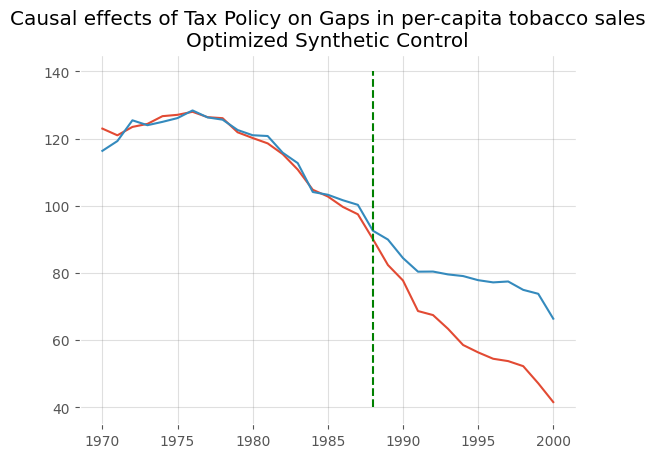

In [65]:
### Optimized Synthetic Control Results

# Observation

(
    plt
    .plot(smoking.query("california").year,
          smoking.query("california").cigsale,
         label = "California before vs. after Treatment")
)

# Compared with (to) What?
# Estimation --> Counterfactual Predictions (What would have happened to California without the policy being implemented)
### This is optimized prediction.

(
    plt
    .plot(smoking.query("california").year,
          synthetic_california_weights_OPTIMIZED,
          label = "Synthetic California before vs. after Treatment (NOT Optimized Yet)")
)

(
    plt
    .vlines(x = 1988,
            ymax = 140,
            ymin = 40,
            color = "green",
            ls = "--")
)

plt.title("Causal effects of Tax Policy on Gaps in per-capita tobacco sales\nOptimized Synthetic Control")

plt.show()

### Post-Strategy Effects Estimation

$$
    \text{Estimated Effect} = Y_{\text{treated, post}} - Y_{\text{TrueSynthetic, post}}
$$




### Team, this is your report on the slide.

In [66]:
smoking_california = smoking.query("california")

In [67]:
synthetic_california_weights_OPTIMIZED

array([116.377, 119.293, 125.465, 124.011, 125.006, 126.128, 128.404,
       126.334, 125.658, 122.577, 121.025, 120.79 , 115.817, 112.722,
       104.134, 103.314, 101.678, 100.311,  92.604,  89.98 ,  84.474,
        80.416,  80.452,  79.6  ,  79.113,  77.891,  77.229,  77.498,
        75.006,  73.835,  66.43 ])

In [68]:
smoking_california =\
(
    smoking_california
    .assign(cigsale_relative_to_counterfactual = smoking_california["cigsale"] - synthetic_california_weights_OPTIMIZED)
)

In [69]:
(
    ggplot(smoking_california,
           aes(x = "year",
               y = "cigsale_relative_to_counterfactual")
          )
    + geom_hline(yintercept = 0,
                 color = "red")
    + geom_vline(xintercept = 1988,
                 color = "green")
    + geom_point()
    + geom_line()
    + labs(title = "Causal effects estimation of cigarette tax",
           subtitle = "Effect size Estimated with Optimization",
           x = "Year (Over Time)",
           y = "Unit of Effects:\nGaps in per-capital cigarette sales per pack")
)

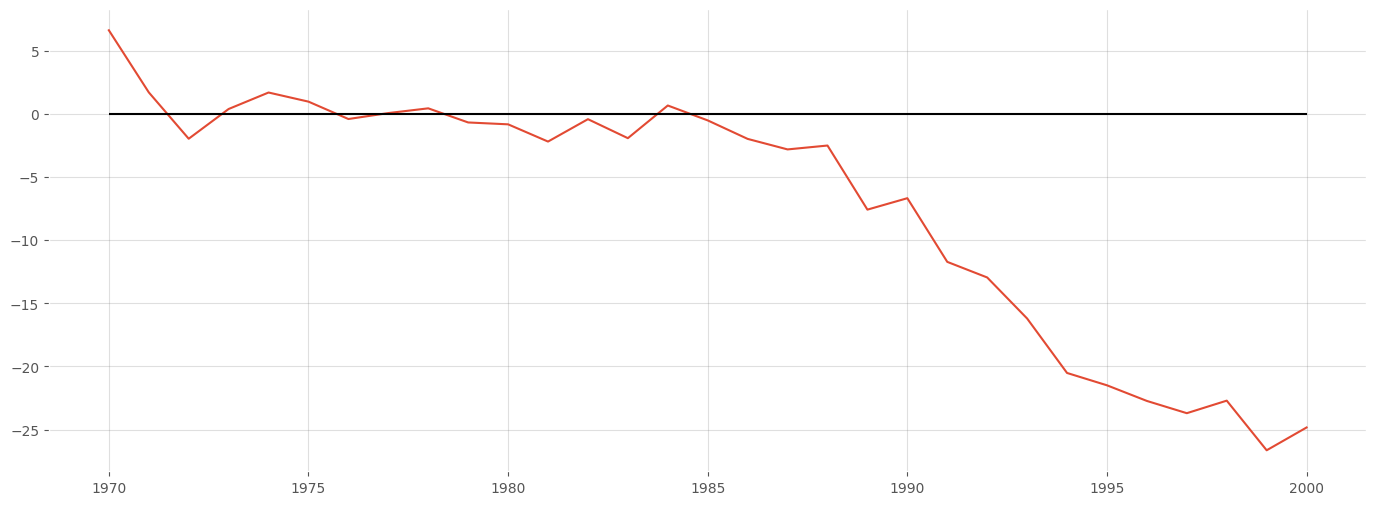

In [70]:
plt.figure(figsize = [17, 6]
          )

(
    plt
    .plot(smoking.query("california").year,
          smoking.query("california").cigsale - synthetic_california_weights_OPTIMIZED,
          label = "Strategy Effects relative to NULL Effects")
)

plt.hlines(y = 0,
           xmin = 1970, 
           xmax = 2000,
           color = "black")

plt.show()

## <a id = "p2">2.</a>  <font color = "green"> What We Learned & What's Next </font>  [back to table of contents](#top)

1. Understanding econometric design is crucial for determining causality, and there are various methods available for exploring causal relationships beyond randomized controlled trials and propensity scoring.
<br>

2. Three major methods for exploring causal inference in econometric design include difference-in-differences, synthetic control, and regression discontinuity.
<br>

3. Standard error is an important factor in determining the accuracy and reliability of causal inference results.
<br>

4. Even with aggregated data, difference-in-differences can still be used to estimate treatment effects, though estimating sample size and standard error may be more challenging.
<br>

5. Synthetic control is a powerful method that allows researchers to create their own control group from multiple untreated units.
<br>

6. Econometric design methods and techniques can be applied to real-world business and policy problems, and the appropriate method should be chosen based on the specific problem and data available.
<br>

7. Econometric design can help identify causal relationships that may not be immediately apparent and is a valuable tool for problem-solving in various fields, including business and policy.

    PERSONAL NOTE:

- Make sure to optimize the construction of synthectic control to avoid overfitting

> `Thank you for working with the script, Team 👍`